# Algoritimos Genéticos na Otimizacao de Portifólio

## Descrição do Problema

Investidores e gestores de fundos enfrentam o desafio de criar portfólios de investimento que maximizem o retorno esperado enquanto minimizam o risco. A composição do portfólio deve equilibrar diferentes ativos financeiros, como ações, títulos, commodities e outros instrumentos financeiros, de acordo com as preferências e restrições do investidor.


## Objetivos
1.   **Maximizar o Retorno Esperado:** O objetivo é selecionar uma combinação de ativos que ofereça o maior retorno possível com base em previsões e análises de mercado.
2.   **Minimizar o Risco:** Reduzir a volatilidade e o risco associado ao portfólio, diversificando os investimentos para proteger contra perdas significativas. Equilibrar Preferências e Restrições: Levar em consideração as preferências do investidor, como tolerância ao risco, horizonte de investimento e restrições específicas (por exemplo, evitar certos setores ou tipos de ativos).


## Critérios de Sucesso:
1.   Aumento do Retorno sobre o Investimento (ROI): O portfólio deve proporcionar um retorno financeiro superior ao de benchmarks ou índices de mercado relevantes.
2.   Redução do Risco: O portfólio deve apresentar menor volatilidade e risco em comparação com alternativas menos diversificadas.
3.   Satisfação do Investidor: O portfólio deve atender às expectativas e preferências do investidor, proporcionando uma experiência de investimento satisfatória.


## Como Algoritmos Genéticos Podem Ajudar
Algoritmos Genéticos (AGs) são uma técnica de otimização inspirada na evolução natural. Eles podem ser utilizados para resolver o problema de design de portfólios de investimento da seguinte maneira:


## Representação do Portfólio
Cada indivíduo na população do AG representa um portfólio de investimento, codificado como um vetor de pesos que indicam a proporção de cada ativo no portfólio.


## Função de Fitness
A função de fitness avalia a qualidade de cada portfólio com base em critérios como retorno esperado e risco. Uma função comum é a razão de Sharpe, que mede o retorno ajustado pelo risco.


## Operadores Genéticos
Os operadores de seleção, cruzamento (crossover) e mutação são aplicados para gerar novas soluções (portfólios) a partir das existentes. A seleção favorece portfólios com melhor desempenho, enquanto o cruzamento e a mutação introduzem diversidade e exploram novas combinações de ativos.

## Evolução
O AG itera através de várias gerações, refinando a população de portfólios até encontrar uma solução otimizada que atenda aos objetivos do investidor.

## Codificacao

Comecando importando as bibliotecas que usaremos no processo.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import random

### Geração da População Inicial
Esta função gera aleatoriamente uma população de indivíduos, representados por arrays de pesos normalizados entre 0 e 1, garantindo que a soma dos pesos de cada indivíduo seja igual a 1 (100%).

In [ ]:
def generate_population(population_size, num_assets):
    population = []
    for _ in range(population_size):
        weights = np.random.random(num_assets)
        population.append(normalize(weights))
    return population

In [ ]:
def normalize(weights):
  weights /= np.sum(weights)
  return weights

### Calculo do Fitness
O calculo da funcao fitness para o problema proposto é baseado no calculo do indice de sharpe.
O Índice de Sharpe é um indicador criado por William Sharpe que permite a avaliação relativa entre o risco e o retorno de um determinado investimento.

> ![Formula de Sharpe](https://files.sunoresearch.com.br/p/uploads/2020/09/%C3%ADndice-de-sharpe-300x130.jpg)
>
> O índice de Sharpe (S) é a relação entre o retorno do fundo (Rf) menos o retorno do ativo livre de risco (Rf) divididos pelo desvio padrão (σp).



In [ ]:
def fitness(historical_data, weights):
    # Calculate daily returns
    returns = historical_data.pct_change().dropna()

    # Define the weights for the portfolio
    weights = np.array(weights)  # Equal weighting for simplicity

    # Calculate expected portfolio return
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualize the mean returns

    # Calculate portfolio volatility
    portfolio_covariance = returns.cov() * 252  # Annualize the covariance matrix
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(portfolio_covariance, weights)))

    # Define the risk-free rate (annualized, e.g., 2%)
    risk_free_rate = 0.02

    # Calculate the Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return sharpe_ratio

### Selecao


In [ ]:
def roulette_wheel_selection(population, fitness):
    total_fitness = np.sum(fitness)
    probabilities = fitness / total_fitness
    cumulative_probabilities = np.cumsum(probabilities)

    r = np.random.rand()
    for i, individual in enumerate(population):
        if r < cumulative_probabilities[i]:
            return individual

In [ ]:
def tournament_selection(population, fitness, tournament_size=3):
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = selected_indices[0]

    for i in selected_indices:
        if fitness[i] > fitness[best_index]:
            best_index = i

    return population[best_index]

In [ ]:
def rank_selection(population, fitness):
    ranks = np.argsort(np.argsort(fitness))
    total_ranks = np.sum(ranks)
    probabilities = ranks / total_ranks
    cumulative_probabilities = np.cumsum(probabilities)

    r = np.random.rand()
    for i, individual in enumerate(population):
        if r < cumulative_probabilities[i]:
            return individual

### Cruzamento

In [ ]:
def single_point_crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1))
    offspring1 = np.concatenate([parent1[:point], parent2[point:]])
    offspring2 = np.concatenate([parent2[:point], parent1[point:]])
    return normalize(offspring1), normalize(offspring2)


In [ ]:
def arithmetic_crossover(parent1, parent2):
    alpha = np.random.rand()
    offspring1 = alpha * parent1 + (1 - alpha) * parent2
    offspring2 = alpha * parent2 + (1 - alpha) * parent1
    return normalize(offspring1), normalize(offspring2)


In [ ]:
def heuristic_crossover(parent1, parent2):
    fitness1 = fitness(data, parent1)
    fitness2 = fitness(data, parent2)

    if fitness1 > fitness2:
        best_parent, worst_parent = parent1, parent2
    else:
        best_parent, worst_parent = parent2, parent1

    beta = np.random.rand()
    difference = best_parent - worst_parent
    offspring1 = best_parent + beta * difference
    offspring2 = worst_parent - beta * difference

    offspring1 = np.clip(offspring1, 0, 1)
    offspring2 = np.clip(offspring2, 0, 1)

    offspring1 /= np.sum(offspring1)
    offspring2 /= np.sum(offspring2)

    return normalize(offspring1), normalize(offspring2)


### Mutacao

In [ ]:
def mutate(individual, mutation_rate, sigma=0.1):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, sigma)
    # Ensure the weights sum to 1
    individual = np.clip(individual, 0, 1)
    individual /= np.sum(individual)
    return individual

### Algoritimo Genético

In [ ]:
def genetic_algorithm(assets_data, population_size=100, generations=1000, selection=rank_selection, crossover=single_point_crossover, mutation_rate=0.1, elitisim=1):
    num_assets = len(assets_data.columns)
    population = generate_population(population_size, num_assets)

    best_portfolio = None
    best_sharpe_ratio =  0

    # Evolution loop with stop condition
    for gen in range(generations):
        # Order population based on best fitness
        population = sorted(population, key=lambda x: fitness(assets_data, x), reverse=True)
        fitness_scores = [fitness(assets_data, x) for x in population]

        best_portfolio = population[0]
        new_fitness = fitness(assets_data, best_portfolio)
        has_improved = new_fitness > best_sharpe_ratio
        best_sharpe_ratio = new_fitness

        # Print only if generation improves from the last
        if has_improved:
            print(f"Generation {np.round(gen, 4)} - Best Portfolio Weights: {best_portfolio} | Best Sharp Ratio: {best_sharpe_ratio}")

        new_population = population[:elitisim]
        while len(new_population) < population_size:
            # Selection
            parent1 = selection(population, fitness_scores)
            parent2 = selection(population, fitness_scores)
            # Crossover
            child1, child2 = crossover(parent1, parent2)
            # print('New child:', child1, child2)
            # Mutation
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            # print('Mutated child:', child1, child2)

            new_population.extend([child1, child2])


        population = new_population

    # Return the best portfolio and its fitness
    return best_portfolio, best_sharpe_ratio

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from math import pi

def show(assets, weights):
  # Number of variables we're plotting
  num_vars = len(assets)

  # Compute angle of each axis
  angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

  # The plot is circular, so we need to "complete the loop"
  # and append the start value to the end.
  weights = np.concatenate((weights, [weights[0]]))
  angles += angles[:1]

  # Create the radar chart
  fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
  ax.fill(angles, weights, color='skyblue', alpha=0.4)
  ax.plot(angles, weights, color='blue', linewidth=2)

  # Draw one axe per variable + add labels
  ax.set_yticklabels([])
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(assets)

  # Add title
  plt.title('Portfolio Weights - Pizza Chart', size=20, color='blue', y=1.1)

  # Show the plot
  plt.show()


In [ ]:
if __name__ == "__main__":
  assets = ['MSFT', 'GOOGL', 'AMZN', 'TSLA', 'AAPL', 'NFLX', 'NVDA', 'PYPL']
  # assets = ['MSFT', 'GOOGL', 'AMZN']

  data = yf.download(assets, period='1y')['Adj Close']

  population_size = 50
  generations = 1000
  mutation_rate = 0.2
  elitism = 1

  df = pd.DataFrame(columns=['run', 'weights', 'fitness'])
  print(df.head())

  print("-------------------")
  # GA - Crossover: Single Point | Selection: Rank
  #weights, sharp = genetic_algorithm(data, population_size, generations, rank_selection, heuristic_crossover, mutation_rate, elitism)
  #df.loc[0] = ['Heuristic/Rank', weights, sharp]
  print("-------------------------")
  # GA - Crossover: Single Point | Selection: Roulette Wheel
  #weights, sharp = genetic_algorithm(data, population_size, generations, rank_selection, arithmetic_crossover, mutation_rate, elitism)
  #df.loc[1] = ['Arithmetic/Rank', weights, sharp]
  print("-------------------------")
  # GA - Crossover: Single Point | Selection: Tournament
  weights, sharp = genetic_algorithm(data, population_size, generations, tournament_selection, heuristic_crossover, mutation_rate, elitism)
  df.loc[2] = ['Heuristic/Tournament', weights, sharp]
  # GA - Crossover: Arithmetic | Selection: Tournament
  weights, sharp = genetic_algorithm(data, population_size, generations, tournament_selection, arithmetic_crossover, mutation_rate, elitism)
  df.loc[3] = ['Arithmetic/Tournament', weights, sharp]

  print(df)

  # [print(assets[i], np.round(np.dot(weights, 100)[i], 2)) for i in range(len(assets))]
  # print(f"Best Sharp Ratio: {np.round(sharp, 2)}")

[*********************100%%**********************]  8 of 8 completed


Empty DataFrame
Columns: [run, weights, fitness]
Index: []
-------------------
-------------------------
-------------------------
Generation 0 - Best Portfolio Weights: [0.1138293  0.21456559 0.07393293 0.24479877 0.11738012 0.21796466
 0.01561024 0.00191839] | Best Sharp Ratio: 1.8131015979624638
Generation 1 - Best Portfolio Weights: [0.08611329 0.26510648 0.         0.27414295 0.10360936 0.2680138
 0.         0.00301412] | Best Sharp Ratio: 1.865303853588703
Generation 2 - Best Portfolio Weights: [0.07423854 0.29192127 0.         0.27644398 0.04721023 0.30709229
 0.         0.0030937 ] | Best Sharp Ratio: 1.8682034422616063
Generation 3 - Best Portfolio Weights: [0.01938045 0.33485815 0.00481097 0.209388   0.         0.42869126
 0.         0.00287117] | Best Sharp Ratio: 1.899414208198878
Generation 4 - Best Portfolio Weights: [0.         0.28000032 0.00790732 0.1687004  0.         0.54140302
 0.         0.00198893] | Best Sharp Ratio: 1.9259674312294817
Generation 5 - Best Portfol

KeyboardInterrupt: 

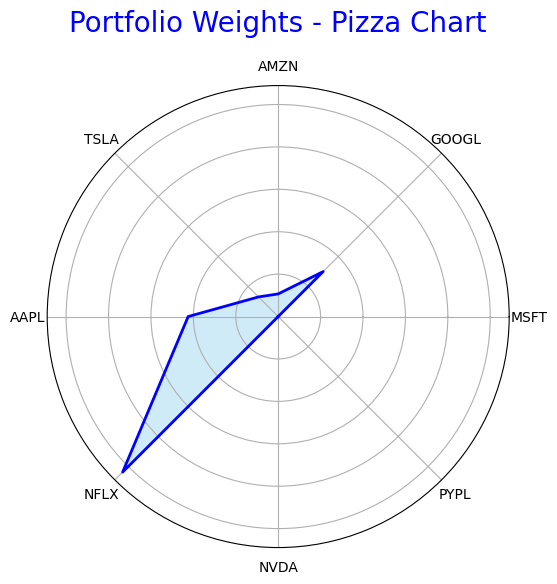

In [ ]:
show(assets, weights)